In [1]:
%load_ext dotenv
%dotenv

In [2]:
import os
import json
import requests
import contextlib

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np

import re
import urllib.parse

import matplotlib.pyplot as plt

In [3]:
NLPAPI_TOKEN = os.getenv("NLPAPI_TOKEN")

In [4]:
from html import unescape
import unicodedata

In [5]:
# import spacy
# from spacy.language import Language

# from spacy_language_detection import LanguageDetector

In [6]:
CONFIG_PATH = "config.json"
OUT_FILE = "traintest.pq"
VERBOSE = False

In [7]:
CONFIG = None
ENGINES = {}
TABLES = {}
BINDS = {}
SESSION = None


def config_template():
    default_conn = {
        "dialect": "postgresql",
        "host": "localhost",
        "port": 5432,
        "dbname": "INVALID",
        "schema": "public",
        "user": "INVALID",
        "passwd": "INVALID",
    }
    return {
        "dbs": {
            "login": default_conn.copy(),
            "sm": default_conn.copy(),
            "exp": default_conn.copy(),
            "ap": default_conn.copy(),
            "blogs": default_conn.copy(),
        }
    }


def get_config():
    global CONFIG
    
    if CONFIG is not None:
        return CONFIG
    if not os.path.exists(CONFIG_PATH):
        with open(CONFIG_PATH, "w") as fout:
            print(json.dumps(config_template(), indent=4, sort_keys=True), file=fout)
        raise ValueError(
            f"config file missing. new file was created at '{CONFIG_PATH}'. "
            "please correct values in file and run again")
    with open(CONFIG_PATH, "r") as fin:
        CONFIG = json.load(fin)
    config_out = {
        "dbs": {
            "login": CONFIG["dbs"]["login"].copy(),
            "sm": CONFIG["dbs"]["sm"].copy(),
            "exp": CONFIG["dbs"]["exp"].copy(),
            "ap": CONFIG["dbs"]["ap"].copy(),
            "blogs": CONFIG["dbs"]["blogs"].copy(),
        }
    }
    config_out["dbs"]["login"]["passwd"] = "..."
    config_out["dbs"]["sm"]["passwd"] = "..."
    config_out["dbs"]["exp"]["passwd"] = "..."
    config_out["dbs"]["ap"]["passwd"] = "..."
    print(f"loaded config\n{json.dumps(config_out, indent=2, sort_keys=True)}")
    return CONFIG


def get_engine(dbname):
    res = ENGINES.get(dbname)
    if res is not None:
        return res
    db = get_config()["dbs"][dbname]
    user = urllib.parse.quote_plus(db["user"])
    passwd = urllib.parse.quote_plus(db["passwd"])
    engine = sa.create_engine(
        f"{db['dialect']}://{user}:{passwd}@{db['host']}:{db['port']}/{db['dbname']}",
        echo=VERBOSE)
    engine = engine.execution_options(
        schema_translate_map={None: db['schema']})
    res = engine, sa.MetaData()
    ENGINES[dbname] = res
    return res


def get_table(dbname, tablename):
    global SESSION
    
    key = (dbname, tablename)
    res = TABLES.get(key)
    if res is not None:
        return res
    SESSION = None
    engine, metadata = get_engine(dbname)
    res = sa.Table(
        tablename,
        metadata,
        autoload_with=engine)
    TABLES[key] = res
    BINDS[res] = engine
    return res


@contextlib.contextmanager
def get_session():
    global SESSION
    
    session = SESSION
    if session is None:
        session = sessionmaker()
        session.configure(binds=BINDS)
        SESSION = session
    with session() as res:
        yield res

In [8]:
def clean(text: str) -> str:
    text = text.strip()
    while True:
        prev_text = text
        text = unescape(text)
        if prev_text == text:
            break
    text = unicodedata.normalize("NFKC", text)
    return re.sub("\n\n\n+", "\n\n", re.sub("[ \t]+", " ", re.sub("\n[ \t]+", "\n", re.sub("\n\n+", "\n", re.sub("\r", "\n", text)))))

def strip_html(text: str) -> str:
    return re.sub(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>", "", re.sub(r"<br\s*/?\s*>", "\n", text.strip()))

In [9]:
strip_html("abc<b>def<br>ghi<a href=\"foo\" c =  '1    2   3   '      >foo<br / >bar</b>lm<   /   a >")

'abcdef\nghifoo\nbarlm'

In [10]:
# global tables
t_tags = get_table("login", "tags")
t_users = get_table("login", "users")

# solution mapping tables
t_sm_pads = get_table("sm", "pads")
t_sm_tagging = get_table("sm", "tagging")

# action plan tables
t_ap_pads = get_table("ap", "pads")
t_ap_tagging = get_table("ap", "tagging")

# experiments tables
t_exp_pads = get_table("exp", "pads")
t_exp_tagging = get_table("exp", "tagging")

loaded config
{
  "dbs": {
    "ap": {
      "dbname": "action_plans_platform",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
      "port": 5432,
      "schema": "public",
      "user": "acclabshqadmin@acclabs-global-login"
    },
    "blogs": {
      "dbname": "blogs",
      "dialect": "postgresql",
      "host": "acclabs.postgres.database.azure.com",
      "passwd": "acclabsblogs@2023",
      "port": 5432,
      "schema": "public",
      "user": "undpacclab@acclabs"
    },
    "exp": {
      "dbname": "experiments_platform",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
      "port": 5432,
      "schema": "public",
      "user": "acclabshqadmin@acclabs-global-login"
    },
    "login": {
      "dbname": "postgres",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
     

/var/folders/ff/zrdw3xx56dd1w9xbl6x_yl0c0000gn/T/ipykernel_70531/3044908452.py:85: SAWarning: Did not recognize type 'ltree' of column 'version'
  res = sa.Table(


In [11]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_sm_pads.c.id))
    stmt = stmt.where(t_sm_pads.c.status >= 2)
    sm_pad_count = int(session.execute(stmt).one()[0])
    print(sm_pad_count)

3388


In [12]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_ap_pads.c.id))
    stmt = stmt.where(t_ap_pads.c.status >= 2)
    ap_pad_count = int(session.execute(stmt).one()[0])
    print(ap_pad_count)

995


In [13]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_exp_pads.c.id))
    stmt = stmt.where(t_exp_pads.c.status >= 2)
    exp_pad_count = int(session.execute(stmt).one()[0])
    print(exp_pad_count)

216


In [14]:
tags = {}
with get_session() as session:
    stmt = sa.select(t_tags.c.id, t_tags.c.name, t_tags.c.type)
    for row in session.execute(stmt):
        tags[row[0]] = (row[1], row[2])

In [15]:
pad_stats = {
    "db": [],
    "status": [],
    "content-length": [],
    "id": [],
}
with get_session() as session:
    for (name, pad_db) in [("sm", t_sm_pads), ("ap", t_ap_pads), ("exp", t_exp_pads)]:
        stmt = sa.select(pad_db.c.status, pad_db.c.full_text, pad_db.c.id)
        for row in session.execute(stmt):
            pad_stats["db"].append(name)
            pad_stats["status"].append(int(row[0]))
            pad_stats["content-length"].append(len(row[1]) if row[1] is not None else 0)
            pad_stats["id"].append(row[2])
pad_stats_df = pd.DataFrame(pad_stats)
pad_stats_df

,db,status,content-length,id
0,sm,0,544,4357
1,sm,3,916,4364
2,sm,0,169,1686
3,sm,3,3090,4571
4,sm,0,1090,6258
...,...,...,...,...
5797,exp,2,4615,235
5798,exp,0,454,237
5799,exp,0,8888,241
5800,exp,2,9413,252


array([[<AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'exp'}>],
       [<AxesSubplot: title={'center': 'sm'}>, <AxesSubplot: >]],
      dtype=object)

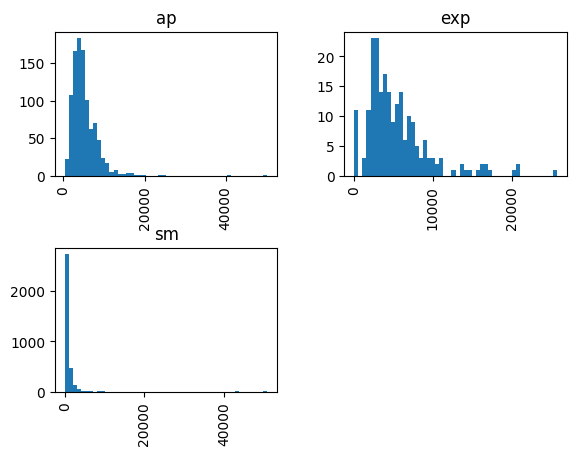

In [16]:
pub_db = pad_stats_df[pad_stats_df["status"] >= 2]
pub_db.hist("content-length", bins=50, by="db")

array([[<AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'exp'}>],
       [<AxesSubplot: title={'center': 'sm'}>, <AxesSubplot: >]],
      dtype=object)

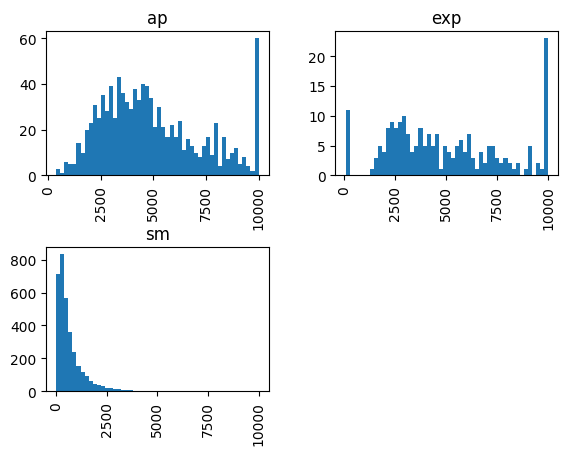

In [17]:
pub_db_clip = pub_db.copy()
pub_db_clip["content-length"].clip(0, 10000, inplace=True)
pub_db_clip.hist("content-length", bins=50, by="db")
# plt.hist([
#     pub_db[pub_db["db"] == "ap"]["content-length"].clip(0, 10000),
#     pub_db[pub_db["db"] == "exp"]["content-length"].clip(0, 10000),
#     pub_db[pub_db["db"] == "sm"]["content-length"].clip(0, 10000),
# ], label=["ap", "exp", "sm"])
# plt.legend(loc='upper right')
# plt.show()

In [18]:
pub_db.groupby("db")["content-length"].describe()

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
ap,995.0,5163.343719,3388.443630,389.0,3129.50,4511.0,6363.50,50240.0
exp,216.0,5468.106481,4118.712209,69.0,2795.25,4381.0,7057.25,25735.0
sm,3388.0,731.202774,1368.652340,19.0,253.00,469.0,864.25,50893.0


In [19]:
pub_db.groupby("db")["content-length"].median()

db
ap     4511.0
exp    4381.0
sm      469.0
Name: content-length, dtype: float64

In [20]:
pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > 856)]

,db,status,content-length,id
1,sm,3,916,4364
3,sm,3,3090,4571
5,sm,2,980,6099
8,sm,2,993,6100
13,sm,3,1254,4366
...,...,...,...,...
4294,sm,3,5125,5870
4321,sm,2,2166,5957
4322,sm,2,50893,5966
4326,sm,2,1903,5977


In [21]:
th = 856
print("\n".join([f"longest above {th} length"] + [
    f"https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id={row['id']}"
    for _, row in pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > th)].sort_values("content-length").tail(20).iterrows()
] + [""] + [f"shortest above {th} length"] + [
    f"https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id={row['id']}"
    for _, row in pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > th)].sort_values("content-length").head(20).iterrows()
]))

longest above 856 length
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5849
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5408
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4329
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=2968
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4564
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5870
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=921
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5759
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5867
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5854
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4384
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5713
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4961
https://acclabs-solutionsmapping.azurewebsites.net/en

In [22]:
# def get_lang_detector(nlp, name):
#     return LanguageDetector(seed=42)

# spacy_nlp_model = spacy.load("en_core_web_sm")
# Language.factory("language_detector", func=get_lang_detector)
# spacy_nlp_model.add_pipe("language_detector", last=True)

def get_lang(doc):
    rlan = requests.post("https://nlpapi.azurewebsites.net/api/language", json={
        "token": NLPAPI_TOKEN,
        "input": doc,
    })
    if not rlan.ok:
        raise ValueError(f"no language for {doc}")
    langs = rlan.json()["languages"]
    lang = langs[0]
    if lang["score"] < 0.99:
        shortened = doc[:80]
        shortened = shortened[:shortened.rfind(" ")]
        print(f"low confidence language {lang} [{langs}]: {doc}")
    return lang["lang"]
    # max_len = 1000000
    # if len(doc) > max_len:
    #     doc = doc[:max_len]
    #     doc = doc[:doc.rfind(" ")]
    # mdoc = spacy_nlp_model(doc)
    # return mdoc._.language

In [ ]:
sm_pads = []

In [24]:
fcountry_cache = {}
sm_pre_ids = {obj["id"] for obj in sm_pads}
with get_session() as session:
    stmt = sa.select(t_sm_pads.c.id, t_sm_pads.c.title, t_sm_pads.c.sections, t_sm_pads.c.full_text, t_sm_pads.c.owner, t_sm_pads.c.status)
    stmt = stmt.where(t_sm_pads.c.status >= 2)
    # stmt = stmt.limit(3)
    for row in session.execute(stmt):
        obj = {}
        fid = row[0]
        if fid in sm_pre_ids:
            print(f"already processed {fid}")
            continue
        obj["id"] = fid
        print(f"processing {fid}")
        ftext = clean(strip_html(row[3]))
        obj["content"] = ftext
        ftitle = row[1]
        if ftitle is None:
            fallback = ftext[:ftext.find("\n")][:80]
            fallback = fallback[:fallback.rfind(" ")]
            ftitle = fallback
            print(f"missing title [{fid}]: {ftitle}")
        else:
            ftitle = clean(ftitle)
        obj["title"] = ftitle
        fstatus = row[5]
        obj["is_public"] = fstatus > 2
        # print("=TITLE=================")
        # print(ftitle)
        # print("=TEXT==================")
        # print(ftext)
        # print("=TAGS==================")
        tstmt = sa.select(t_sm_tagging.c.tag_id)
        tstmt = tstmt.where(t_sm_tagging.c.pad == fid)
        ftags = []
        fsdgs = []
        for tag in session.execute(tstmt):
            t_name, t_type = tags[tag[0]]
            if t_type == "thematic_areas":
                # print("thematic_areas", t_name)
                ftags.append(t_name)
            if t_type == "sdgs":
                # print("sdgs", t_name)
                fsdgs.append(t_name)
        obj["tags"] = ftags
        obj["sdgs"] = fsdgs
        # print("=COUNTRY===============")
        fowner_uuid = row[4]
        fcountry = fcountry_cache.get(fowner_uuid)
        if fcountry is None:
            fcstmt = sa.select(t_users.c.iso3).where(t_users.c.uuid == fowner_uuid)
            fcountry = session.execute(fcstmt).scalar_one()
            print(f"discovered new country: {fcountry}")
            fcountry_cache[fowner_uuid] = fcountry
        # print(fcountry)
        obj["country"] = fcountry
        # print("=LANGUAGE==============")
        flang = get_lang(ftext)
        # print(flang)
        # print()
        obj["lang"] = flang
        sm_pads.append(obj)
len(sm_pads)

already processed 4364
already processed 4571
already processed 6099
already processed 6100
already processed 4145
already processed 4366
already processed 4361
already processed 4358
already processed 4939
already processed 5053
already processed 4332
already processed 6101
already processed 976
already processed 4346
already processed 39
already processed 5058
already processed 4352
already processed 5065
already processed 5333
already processed 5873
already processed 4591
already processed 6103
already processed 6264
already processed 4384
already processed 6265
already processed 2330
already processed 4509
already processed 4546
already processed 4589
already processed 4766
already processed 5406
already processed 5382
already processed 3003
already processed 3039
already processed 3745
already processed 4768
already processed 4816
already processed 4743
already processed 4950
already processed 5385
already processed 3733
already processed 4996
already processed 1644
already proces

3388

In [25]:
sm_pads[:10]

[{'id': 4364,
  'content': 'Tikikil stove\n\nGIZ\nOffice contact GIZ Office Ethiopia Country Director Peter Palesch giz-aethiopien@giz.de Office address GIZ Office Ethiopia Kazanchis, Kirkos Sub City, Woreda 08 Addis Ababa 00251-11-5180200 00251-11-5540764 giz-aethiopien@giz.de\nYes\nTikikil stove is used for cooking. It uses firewood as fuel which is continuously fed into the combustion chamber. The stove has a cylindrical inner clay liner as combustion chamber, covered with galvanized sheet metal on the outside. The 4cm thick liner has internal diameter of 11cm and is 23.5cm high. At its bottom is an 11cmX11cm opening as fuel and air inlet. \n20 USD\nscale up\nmore than 42,000\nYes\nNo\nhttps://energypedia.info/images/2/2c/GIZ_HERA_2012_Tikikil_Stove_ET.pdf\nhttps://energypedia.info/images/2/2c/GIZ_HERA_2012_Tikikil_Stove_ET.pdf\nDIY / open source\nYes\nProduct\nAvailable in market',
  'title': 'Tikikil stove',
  'is_public': True,
  'tags': ['clean energy', 'affordable energy', 'sto

In [28]:
with open("sm_pads.json", "w", encoding="utf-8") as fout:
    json.dump({
        "pads": sm_pads,
    }, fout, sort_keys=True, indent=2)

In [29]:
sm_tag_counts = {}
with get_session() as session:
    stmt = sa.select(t_sm_tagging.c.tag_id, sa.func.count(t_sm_tagging.c.tag_id))
    stmt = stmt.group_by(t_sm_tagging.c.tag_id).order_by(sa.func.count(t_sm_tagging.c.tag_id).desc())
    for theme in [True, False]:
        print_count = 10
        for row in session.execute(stmt):
            t_name, t_type = tags[row[0]]
            if (t_type == "thematic_areas") != theme:
                continue
            if print_count > 0:
                print(f"{row[1] / sm_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
                print_count -= 1
            sm_tag_counts[t_name] = int(row[1])
        print()

8.44% 286 circular economy (thematic_areas)
7.11% 241 agriculture (thematic_areas)
6.05% 205 waste management (thematic_areas)
5.99% 203 innovation (thematic_areas)
5.87% 199 covid-19 response (thematic_areas)
4.99% 169 health (thematic_areas)
4.78% 162 recycling (thematic_areas)
4.46% 151 environment friendly (thematic_areas)
4.31% 146 youth (thematic_areas)
4.25% 144 clean energy (thematic_areas)

39.26% 1330 Sustainable cities and communities (sdgs)
34.92% 1183 Responsible consumption and production (sdgs)
27.69% 938 Climate action (sdgs)
26.15% 886 Decent work and economic growth (sdgs)
25.74% 872 Industry, innovation and infrastructure (sdgs)
22.49% 762 Good health and well-being (sdgs)
16.17% 548 Affordable and clean energy (sdgs)
14.58% 494 No poverty (sdgs)
13.37% 453 Zero hunger (sdgs)
12.54% 425 Reduced innequalities (sdgs)



In [31]:
# ap_tag_counts = {}
# with get_session() as session:
#     stmt = sa.select(t_ap_tagging.c.tag_id, sa.func.count(t_ap_tagging.c.tag_id))
#     stmt = stmt.group_by(t_ap_tagging.c.tag_id).order_by(sa.func.count(t_ap_tagging.c.tag_id).desc())
#     for theme in [True, False]:
#         print_count = 10
#         for row in session.execute(stmt):
#             t_name, t_type = tags[row[0]]
#             if (t_type == "thematic_areas") != theme:
#                 continue
#             if print_count > 0:
#                 print(f"{row[1] / ap_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
#                 print_count -= 1
#             ap_tag_counts[t_name] = int(row[1])
#         print()

In [32]:
# exp_tag_counts = {}
# with get_session() as session:
#     stmt = sa.select(t_exp_tagging.c.tag_id, sa.func.count(t_exp_tagging.c.tag_id))
#     stmt = stmt.group_by(t_exp_tagging.c.tag_id).order_by(sa.func.count(t_exp_tagging.c.tag_id).desc())
#     for theme in [True, False]:
#         print_count = 10
#         for row in session.execute(stmt):
#             t_name, t_type = tags[row[0]]
#             if (t_type == "thematic_areas") != theme:
#                 continue
#             if print_count > 0:
#                 print(f"{row[1] / exp_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
#                 print_count -= 1
#             exp_tag_counts[t_name] = int(row[1])
#         print()

OperationalError: (psycopg2.OperationalError) could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out

[SQL: SELECT public.tagging.tag_id, count(public.tagging.tag_id) AS count_1 
FROM public.tagging GROUP BY public.tagging.tag_id ORDER BY count(public.tagging.tag_id) DESC]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
# all_tags = [(tid, tname) for (tid, (tname, ttype)) in tags.items() if ttype == "thematic_areas"]
# all_tags[:10], all_tags[-10:]

In [ ]:
# rng = np.random.default_rng(42)

In [ ]:
# train_size = 1000
# test_size = 1000
# train_test_ixs = list(rng.choice(list(range(sm_pad_count)), train_size + test_size, replace=False))
# is_train = set(train_test_ixs[:train_size])
# is_test = set(train_test_ixs[train_size:])

In [ ]:
# content = {
#     "id": [],
#     "stage": [],
#     "db": [],
#     "country": [],
#     "title": [],
#     "text": [],
#     "lang": [],
# }
# ctags = {}
# ctagnames = []
# for (tag_id, tag_name) in all_tags:
#     col_name = f"tag_{tag_name}"
#     ctagnames.append(col_name)
#     ctags[tag_id] = col_name
#     content[col_name] = []
# tables = [
#     ("sm", t_sm_pads, t_sm_tagging),
#     ("ap", t_ap_pads, t_ap_tagging),
#     ("exp", t_exp_pads, t_exp_tagging),
# ]
# country_cache = {}
# with get_session() as session:
#     for (t_name, t_pads, t_tagging) in tables:
#         stmt = sa.select(t_pads.c.id, t_pads.c.title, t_pads.c.full_text, t_pads.c.owner)
#         stmt = stmt.where(t_pads.c.status >= 2)
#         cur_ix = 0
#         for row in session.execute(stmt):
#             cur_ix += 1
#             body = clean(strip_html(row[2]))
#             pad_id = row[0]
#             info = {"id": f"{pad_id}", "db": f"{t_name}"}
#             if len(body) <= 80:
#                 print(f"short body ({len(body)}). skipping... [{info}]: {body}")
#                 continue
#             if t_name == "sm":
#                 stage = "validation"
#                 if cur_ix in is_train:
#                     stage = "train"
#                 if cur_ix in is_test:
#                     stage = "test"
#             else:
#                 stage = "validation"
#             owner_uuid = row[3]
#             country = country_cache.get(owner_uuid)
#             if country is None:
#                 cstmt = sa.select(t_users.c.iso3).where(t_users.c.uuid == owner_uuid)
#                 country = session.execute(cstmt).scalar_one()
#                 # print(f"discovered new country: {country}")
#                 country_cache[owner_uuid] = country
#             content["country"].append(country)
#             content["id"].append(pad_id)
#             content["stage"].append(stage)
#             content["db"].append(t_name)
#             title = row[1]
#             if title is None:
#                 fallback = body[:body.find("\n")][:80]
#                 fallback = fallback[:fallback.rfind(" ")]
#                 title = fallback
#                 print(f"missing title [{info}]: {title}")
#             content["title"].append(clean(title))
#             content["text"].append(body)
#             lang = get_lang(body)
#             if lang["score"] < 0.99:
#                 shortened = body[:80]
#                 shortened = shortened[:shortened.rfind(" ")]
#                 print(f"low confidence language {lang} [{info}]: {shortened}")
#             content["lang"].append(lang["language"])
#             for cname in ctagnames:
#                 content[cname].append(False)
#             tstmt = sa.select(t_tagging.c.tag_id)
#             tstmt = tstmt.where(t_tagging.c.pad == row[0])
#             for tag in session.execute(tstmt):
#                 cname = ctags.get(tag[0])
#                 if cname is not None:
#                     content[cname][-1] = True
# df = pd.DataFrame(content, columns=["stage", "id", "db", "country", "lang", "title", "text"] + sorted(ctagnames))
# final_tags = []
# for cname in ctagnames:
#     if df[cname].all() or not df[cname].any():
#         print(f"drop {cname}")
#         del df[cname]
#     else:
#         final_tags.append(cname)

In [ ]:
# df

In [ ]:
# show_amount = 50
# for cname in final_tags:
#     train_cat_count = df.loc[df["stage"] == "train", cname].sum()
#     test_cat_count = df.loc[df["stage"] == "test", cname].sum()
#     validation_cat_count = df.loc[df["stage"] == "validation", cname].sum()
#     text = f"{train_cat_count} {test_cat_count} {validation_cat_count} {cname}"
#     if show_amount > 0:
#         print(text)
#         if not test_cat_count:
#             print("^" * len(text))
#         show_amount -= 1

In [ ]:
# df.to_parquet(OUT_FILE)